In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ast import literal_eval
import osmnx as ox

from shapely.geometry import Polygon
import matplotlib
import networkx as nx

In [2]:
# reading road construction polygons
road_construction = pd.read_csv('data/hungary_road_construction.csv',sep=";",index_col=None,header=None)
road_construction.columns = ["name","year","month","day","points"]
road_construction.head()

,name,year,month,day,points
0,Polgári Tisza-hid,2002,10.0,1.0,"[[21.0552074392,47.8535623743],[21.0510017355,..."
1,Szekszard Szent Laszlo-hid,2003,7.0,4.0,"[[18.8875748594,46.3498790197],[18.887274452,4..."
2,Dunaujvaros Pentele-hid,2007,7.0,23.0,"[[18.9884702044,46.8892504416],[18.9010945635,..."
3,M3 Fuzesabony-Polgar,2002,NaN,NaN,"[[20.4282135249,47.7251911319],[20.4055542231,..."
4,M3 Polgar-Gorbehaza,2004,9.0,NaN,"[[21.2596564086,47.7818136227],[21.1813788207,..."


<AxesSubplot:>

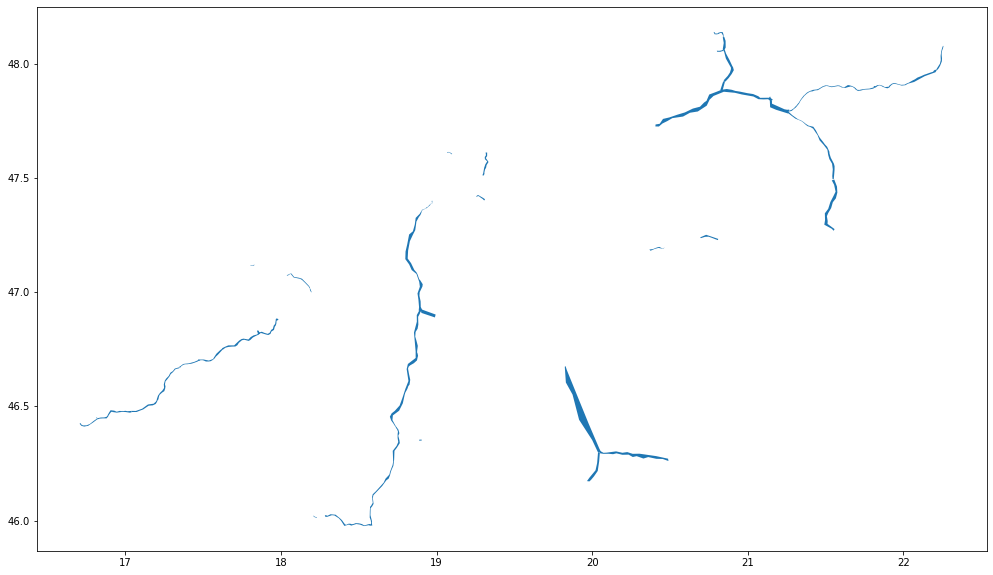

In [3]:
# converting list of list strings to actual Python objects
road_construction["points"] = road_construction["points"].map(literal_eval)
# converting list of lists to Polygon objects
road_construction["geometry"] = road_construction["points"].map(Polygon)
# converting pandas to geodataframe
road_construction = gpd.GeoDataFrame(road_construction, geometry = "geometry", crs = "epsg:4326")
fig,ax = plt.subplots(1,1,figsize=(20,10))
road_construction.plot(ax=ax)

In [4]:
# reading node and edge shapefiles
nodes_s = gpd.read_file("data/hungary_main_roads_nodes.shp").set_index("osmid")
edges_s = gpd.read_file("data/hungary_main_roads_edges.shp")
# more complicated data has been stored separately from the shapefile
temp = pd.read_csv("data/hungary_main_roads_edges_extension.csv")
temp["osmid"] = temp["osmid"].map(literal_eval)
edges_s = pd.merge(edges_s,temp)
del temp

In [5]:
intersections = gpd.sjoin(edges_s, road_construction)
intersections.head()

,u,v,key,geometry,osmid,oneway,lanes,ref,highway,length,...,width,service,maxspeed_new,speedcolor,index_right,name_right,year,month,day,points
79,686550313,2144826801,0,"LINESTRING (18.27575 46.05365, 18.27524 46.052...","[326353477, 54511341, 326353478]",False,2,578,primary,3998.054,...,NaN,NaN,90.000000,#21918c,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."
85,686550337,688358294,0,"LINESTRING (18.27652 46.05478, 18.27674 46.054...","[355078186, 355078192, 355078198, 355078200, 3...",False,"['6', '2', '4', '3']",57,primary,26414.185,...,NaN,NaN,84.767127,#26818e,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."
90,686550399,2144826788,0,"LINESTRING (18.28787 46.01851, 18.28749 46.019...","[204479810, 308721679, 204479807]",False,2,578,primary,304.186,...,NaN,NaN,90.000000,#21918c,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."
91,686550399,2144826756,0,"LINESTRING (18.28787 46.01851, 18.28788 46.018...",204479848,True,1,578,primary,47.231,...,NaN,NaN,90.000000,#21918c,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."
95,687431058,687433176,0,"LINESTRING (18.23613 46.01250, 18.23791 46.012...","[269888480, 269888481, 149403364, 293029797, 1...",True,"['2', '3']",M60,motorway,4157.165,...,NaN,NaN,125.888139,#dde318,16,M6 Dunaujvaros-Pecs,2010,3.0,31.0,"[[18.5332377694, 45.9757037252], [18.506115271..."


<AxesSubplot:>

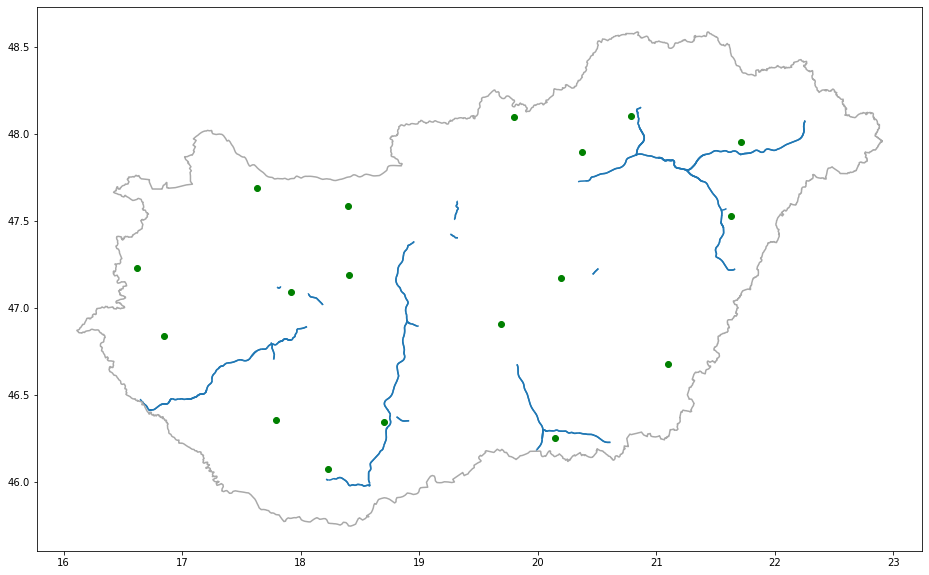

In [6]:
settlements = gpd.read_file('../../data/hungary-osm/gis_osm_places_free_1.shp')
fig,ax = plt.subplots(1,1,figsize=(20,10))
intersections[intersections["maxspeed_new"]>90].plot(ax=ax)
gpd.read_file('../../data/hungary-gadm/gadm36_HUN_0.shp').boundary.plot(ax=ax,color='darkgrey')
settlements[settlements["fclass"]=="city"].plot(ax=ax,color="green")

In [44]:
def trim_graph(year):
    """
    This function takes a year as an input, deletes edges form the edge dataframe
    that are newer than the given year, searches for largest connected component in
    the network constructed from the smaller edge set, and returns an osmnx graph
    using only the largest connected component.
    """
    trimmed_edges = edges_s[edges_s.index.map(lambda i: i not in intersections[(intersections["year"]>year)&(intersections["maxspeed_new"]>90)].index)].set_index(["u","v","key"])
    trimmed_edges["time"] = trimmed_edges["length"]/1000 / trimmed_edges["maxspeed_new"]
    G = ox.graph_from_gdfs(nodes_s,trimmed_edges)
    conn_comp_nodes = sorted(nx.connected_components(ox.get_undirected(G)),key=len)[-1]
    return \
        ox.graph_from_gdfs(nodes_s.loc[conn_comp_nodes],trimmed_edges[trimmed_edges.index.map(lambda i: i[0] in conn_comp_nodes and i[1] in conn_comp_nodes)]),\
        nodes_s.loc[conn_comp_nodes]

In [33]:
def closest_node(i):
    city = cities.iloc[i,:]["geometry"]
    return nodes_test.distance(city).idxmin()

In [13]:
cities = settlements[settlements["fclass"]=="city"]
cities["node"] = cities.reset_index().index.map(closest_node)

In [39]:
c1 = 360352917 # Pecs
c2 = 1403791829 # Szeged

In [45]:
graphs = {}
nodes = {}
for y in range(2002,2013):
    test, nodes_test = trim_graph(y)
    graphs[y] = ox.get_undirected(test)
    nodes[y] = nodes_test
#     ox.io.save_graphml(trim_graph(y),f'data/hungary_road_network_{y}.graphml')

In [62]:
cities[cities["osm_id"]==c1]["geometry"]

GeoSeries([], Name: geometry, dtype: geometry)

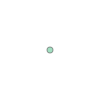

In [65]:
cities[cities["osm_id"]==c1_orig]["geometry"].iloc[0]

In [73]:
from itertools import product

In [74]:
sp = {}
res = []
for y in range(2002,2013):
    for c1_orig,c2_orig in product(cities["osm_id"],cities["osm_id"]):
        if c1_orig<c2_orig:
            c1_geom = cities[cities["osm_id"]==c1_orig]["geometry"].iloc[0]
            c2_geom = cities[cities["osm_id"]==c2_orig]["geometry"].iloc[0]
            c1 = nodes[y].distance(c1_geom).idxmin()
            c2 = nodes[y].distance(c2_geom).idxmin()
            sp_nodelist = nx.shortest_path(graphs[y], source = c1, target = c2, weight="time")
            sp_edgelist = list(zip(sp_nodelist[:-1],sp_nodelist[1:]))
            sp[y] = sp_edgelist
            res.append({
                "year": y,
                "source" : cities[cities["osm_id"]==c1_orig]["name"].iloc[0],
                "target" :cities[cities["osm_id"]==c2_orig]["name"].iloc[0],
                "travel_time": nx.shortest_path_length(graphs[y], source = c1, target = c2, weight="time"),
                "length": nx.shortest_path_length(graphs[y], source = c1, target = c2, weight="length"),
            })

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c2 = nodes[y].distance(c2_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  c1 = nodes[y].distance(c1_geom).idxmin()
/tmp/ipykernel_60460/3177087601.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS bef

<AxesSubplot:>

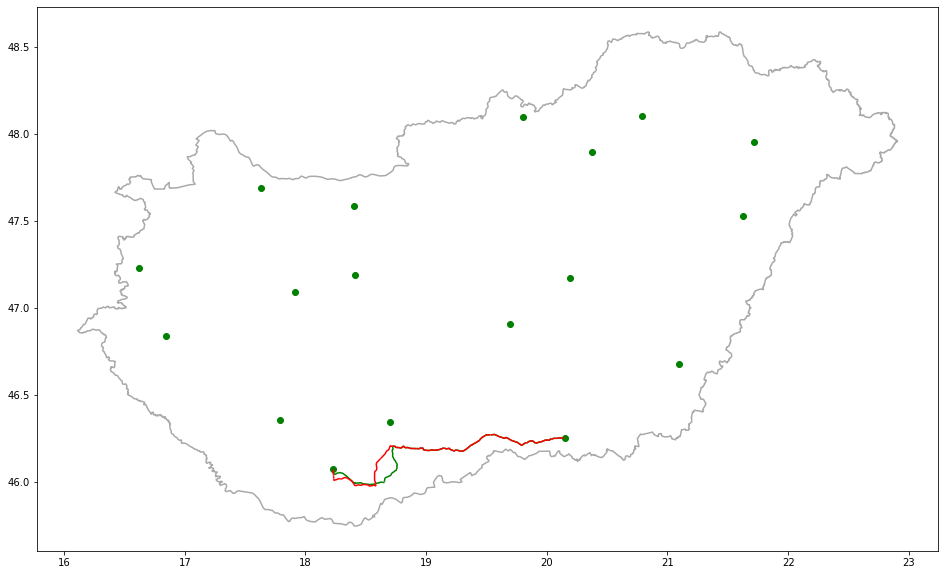

In [57]:
fig,ax = plt.subplots(1,1,figsize=(20,10))

gpd.read_file('../../data/hungary-gadm/gadm36_HUN_0.shp').boundary.plot(ax=ax,color='darkgrey')
settlements[settlements["fclass"]=="city"].plot(ax=ax,color="green")
edges_s[edges_s.apply(lambda r: (r["u"],r["v"]) in set(sp[2002]),axis=1)].plot(ax=ax,color='g')
edges_s[edges_s.apply(lambda r: (r["u"],r["v"]) in set(sp[2012]),axis=1)].plot(ax=ax,color='r')

In [76]:
pd.DataFrame.from_dict(res).to_csv("data/shortest_paths.csv",index=False,header=True)